In [2]:
import pickle
import pandas as pd
import geopandas as gp
#gp.options.use_pygeos = False
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex']=True

import numpy as np
from matplotlib import cm
from matplotlib.lines import Line2D
import pygeos
import sklearn
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit
from tqdm import trange
#Packages from Scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, LinearRegression, ElasticNetCV
from sklearn.svm import LinearSVR
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, median_absolute_error, mean_gamma_deviance, r2_score, max_error

import hashlib

print(sklearn.__version__)


0.23.2


In [3]:
! python --version

Python 3.8.2


In [4]:
# State FIPS codes
state_codes = {'AL':'01','AZ':'04','AR':'05',
               'CA':'06','CO':'08','CT':'09','DE':'10',
               'FL':'12','GA':'13','HI':'15','ID':'16',
               'IL':'17','IN':'18','IA':'19','KS':'20',
               'KY':'21','LA':'22','ME':'23','MD':'24',
               'MA':'25','MI':'26','MN':'27','MS':'28',
               'MO':'29','MT':'30','NE':'31','NV':'32',
               'NH':'33','NJ':'34','NM':'35','NY':'36',
               'NC':'37','ND':'38','OH':'39','OK':'40',
               'OR':'41','PA':'42','RI':'44','SC':'45',
               'SD':'46','TN':'47','TX':'48','UT':'49',
               'VT':'50','VA':'51','WA':'53','WV':'54',
               'WI':'55','WY':'56'}

In [5]:
def FIPS_format(string):
    # Helper function to reformat FIPS codes in the ACS dataset
    return string.split('US')[1]

def loadACS_CSV(filename):
    # Helper function to load and format a .csv file from ACS and index it by FIPS code
    data = pd.read_csv(filename,
                       encoding='latin1',
                       low_memory=False,header=1,
                       dtype={'Id2':'str'})
    data.index = data['id'].apply(FIPS_format)
    data.index.name = 'FIPS'
    data = data.drop('id',axis=1)
    data = data.rename({'Geography':'County Name'}, axis =1 )
    return data

# Load Census data from CSV files
demographics = loadACS_CSV(filename='data/ACS_data/ACSDP5Y2019DP05.csv')
economics = loadACS_CSV(filename='data/ACS_data/ACSDP5Y2019DP03.csv')
social = loadACS_CSV(filename='data/ACS_data/ACSDP5Y2019DP02.csv')

# Merge the three DataFrames into a single DataFrame
cols_to_use = economics.columns.difference(demographics.columns)
dfNew = pd.merge(demographics,
                 economics[cols_to_use],
                 left_index=True,
                 right_index=True,
                 how='inner')
cols_to_use = social.columns.difference(dfNew.columns)
ACS_data = pd.merge(dfNew,
                    social[cols_to_use],
                    left_index=True,
                    right_index=True,
                    how='inner')

# Remove 'Margin of Error' columns and rows with missing data
ACS_data = ACS_data[ACS_data.columns[np.where(['Margin' not in c for c in ACS_data.columns])]]
ACS_data.dropna(axis=0, how='any', inplace=True)

In [6]:
def add_0(myStr):
    """
    Helper function to change a FIPS code integer into a standardized string with length 5
    Also, fixes Shannon county -> Oglala Lakota county issue
    """
    if myStr == 46113:
        return '46102'
    if int(len(str(int(myStr)))<5):
        return '0'+str(myStr)
    else:
        return str(myStr)
    
def loadElectionAtlas_CSV(filename):
    # Helper function to load and format a .csv file from ACS and index it by FIPS code
    data = pd.read_csv(filename,
                       encoding='latin1',
                       low_memory=False,
                       header=1)
    data.index = data['fips'].apply(add_0)
    data.index.name = 'FIPS'
    data = data.drop('fips',axis=1)
    return data

election_results_2020 = loadElectionAtlas_CSV(filename='data/election_data/2020_counties.csv')
# Biden is 'vote1', Trump is 'vote2' in this file
election_results_2020 = election_results_2020.rename(columns={'vote1': 'votes_dem_2020', 'vote2':'votes_gop_2020'})

# Voting data from 2012 and 2016 [from GitHub]
election_results_prev = pd.read_excel('data/election_data/US_County_Level_Presidential_Results_08-16.xlsx',
                                      'Sheet 1',
                                      header=1,
                                      usecols=list(range(0,100)),
                                      skiprows=range(2,31)) # Remove rows related to Alaska, as we don't have county-equivalent data
election_results_prev.index = election_results_prev['combined_fips'].apply(add_0)

# Merge 2020 and previous year data
election_results = pd.merge(election_results_2020,
                            election_results_prev,
                            left_index=True,
                            right_index=True,
                            how='inner')

# Filter out third party and extraneous data
election_results = election_results[['votes_dem_2020',
                                     'votes_gop_2020',
                                     'votes_dem_2016',
                                     'votes_gop_2016',
                                     'votes_dem_2012',
                                     'votes_gop_2012']]
# Compute vote shares
election_results['per_dem_2012'] = election_results['votes_dem_2012']/(election_results['votes_dem_2012']+election_results['votes_gop_2012'])
election_results['per_gop_2012'] = election_results['votes_gop_2012']/(election_results['votes_dem_2012']+election_results['votes_gop_2012'])
election_results['per_dem_2016'] = election_results['votes_dem_2016']/(election_results['votes_dem_2016']+election_results['votes_gop_2016'])
election_results['per_gop_2016'] = election_results['votes_gop_2016']/(election_results['votes_dem_2016']+election_results['votes_gop_2016'])
election_results['per_dem_2020'] = election_results['votes_dem_2020']/(election_results['votes_dem_2020']+election_results['votes_gop_2020'])
election_results['per_gop_2020'] = election_results['votes_gop_2020']/(election_results['votes_dem_2020']+election_results['votes_gop_2020'])

In [7]:
#Load & format the data
def load_county_shapefile(filename):
    shapeDF = gp.read_file(filename)
    shapeDF = shapeDF.set_index('GEOID')
    shapeDF.index.name='FIPS'
    shapeDF = shapeDF.sort_index()
    return shapeDF
countyShapes = load_county_shapefile('data/shapefiles/cb_2017_us_county_5m.shp')


In [8]:
# get p-values for each value of |sigma|
def global_p_value(s, Zz):
    return len(np.where(Zz>np.abs(s))[0])/len(Zz)

def sigma_given_p(p):
    # two-tailed (extrema) sigma from a p-value
    x = np.linspace(0, 200, 50000)
    g = 2.0/np.sqrt(2*np.pi)*np.exp(-(x**2)/2.)
    c = np.cumsum(g)/sum(g)
    value = x[np.argmin(np.abs(c-(1.0-p)))]
    return value


In [9]:
def gaussian(x, x0, sigma, A):
    return A/np.sqrt(2.*np.pi*sigma**2)*np.exp(-(x-x0)**2/(2*sigma**2))

In [10]:
dfNew = pd.merge(ACS_data,
                 election_results,
                 left_index=True,
                 right_index=True,
                 how='inner')
usa = pd.merge(countyShapes,
               dfNew,
               left_index=True,
               right_index=True,
               how='inner')

usa.dropna(axis=0, how='any', inplace=True)

In [11]:
# Add some interesting variables in case they become useful

usa['GOPChange2016'] = usa['per_gop_2016'] - usa['per_gop_2012']
usa['GOPChange2020'] = usa['per_gop_2020'] - usa['per_gop_2016']

In [12]:
label = 'per_gop_2020'

In [13]:
# Define the features to train on 
# Ignore features with missing data or strings

features =  []
for c in usa.columns:
    if '2020' not in c:
        # Add Census features first
        if 'Estimate' in c or 'Percent' in c:
            try:
                usa[c] = usa[c].astype(float)
                features.append(c)
            except:
                pass

# Add in electoral features
features = features + ['votes_dem_2016', 'votes_gop_2016','votes_dem_2012', 'votes_gop_2012', 'per_dem_2012', 'per_gop_2012',
             'per_dem_2016', 'per_gop_2016','GOPChange2016']

In [14]:
# Build and train ElasticNet model
model = Pipeline([('std_scaler', StandardScaler()),('enet', ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]))])
model.fit(usa[features], usa[label])


/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014316159344477275, tolerance: 0.008278764828079307
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('enet',
                 ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]))])

In [15]:
predictions = model.predict(usa[features])
results_global = pd.DataFrame(columns=['Residuals', 'geometry', 'abs_residuals', 'predicted', 'actual'])
results_global['Residuals'] = 100.*(usa[label]-predictions)
results_global['abs_residuals'] = np.abs(results_global['Residuals'])
results_global['predicted'] = predictions
results_global['actual'] = usa[label]
results_global['geometry'] = usa['geometry'].values


In [16]:
model['enet'].alpha_

0.0016096666742027232

In [17]:
model['enet'].l1_ratio_

0.1

In [18]:
np.sqrt(mean_squared_error(usa['per_gop_2020'], model.predict(usa[features])))

0.01495879438163458

In [20]:
# Account for look-elsewhere effect
n_counties = len(results_global)
Zz_global = np.zeros((1000000))
for i in trange(1000000):
    z = np.random.randn(n_counties)
    Zz_global[i] = np.max(np.abs(z))

100%|██████████| 1000000/1000000 [01:43<00:00, 9618.91it/s]


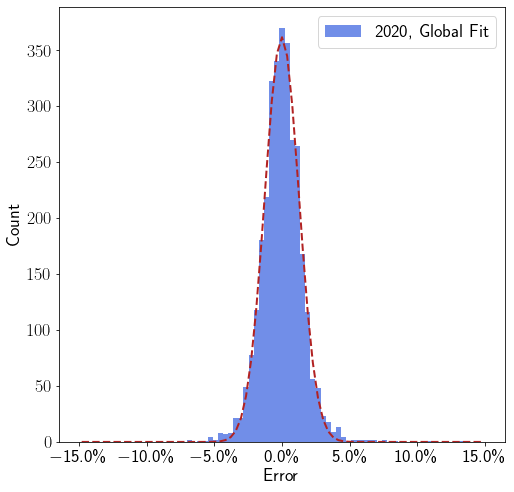

In [23]:
fig = plt.figure(figsize = [8,8])

bins = np.linspace(-15, 15, 80)
plt.rcParams['font.size'] = 18
plt.hist(results_global['Residuals'], bins = bins, lw=3, color='royalblue', histtype='stepfilled', alpha = 0.75, label = '2020, Global Fit')
#plt.hist(residuals2016['Residuals'], bins = np.linspace(-15, 15, 80),lw=3., color='indianred', histtype='step', label = '2016, Global Fit')
plt.legend()
plt.ylabel('Count')
plt.xlabel('Error')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())


#plt.hist(residuals_test['Residuals'].values, bins = np.linspace(-10, 10, 100))
bin_heights, bin_borders= np.histogram(results_global['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])
plt.plot(bin_centers, gaussian(bin_centers, *popt), lw = 2., c= 'firebrick', ls = '--')
plt.legend()
plt.savefig('MSE_comparison_2020_2016_left.pdf',bbox_inches='tight')
plt.show()



In [26]:
# Examine the top-ten most anomalous counties
predictions_sorted = predictions[np.argsort(results_global['abs_residuals'])[::-1]]
k = 0
for idx in results_global.sort_values(by='abs_residuals', ascending=False).index[:10]:
    print('Name: ' + str(usa.loc[idx,'Geographic Area Name']))
    print('Predicted GOP share: '+str(predictions_sorted[k]))
    print('Actual GOP share: ' + str(usa.loc[idx, 'per_gop_2020']))
    print('Residual: ' + str(results_global.loc[idx, 'Residuals']))
    print('Local significance: ' + str(results_global.loc[idx, 'Residuals']/popt[1]))
    if results_global.loc[idx, 'Residuals']/popt[1]<6:
        print('Global significance: '+ str(sigma_given_p(global_p_value(results_global.loc[idx, 'Residuals']/popt[1], Zz_global))))
    print('')
    k += 1

Name: Starr County, Texas
Predicted GOP share: 0.34236546029844855
Actual GOP share: 0.47478411053540587
Residual: 13.24186502369573
Local significance: 10.438269180619544

Name: Maverick County, Texas
Predicted GOP share: 0.3421318678864407
Actual GOP share: 0.452310523894038
Residual: 11.01786560075973
Local significance: 8.685139648442105

Name: Parmer County, Texas
Predicted GOP share: 0.7297332688142928
Actual GOP share: 0.813953488372093
Residual: 8.422021955780023
Local significance: 6.638893544240657

Name: Reeves County, Texas
Predicted GOP share: 0.5399456355971872
Actual GOP share: 0.6177034804055905
Residual: 7.775784480840331
Local significance: 6.129478842765191

Name: Edwards County, Texas
Predicted GOP share: 0.7639629870347179
Actual GOP share: 0.8416588124410933
Residual: 7.769582540637543
Local significance: 6.124589990540602

Name: Upton County, Texas
Predicted GOP share: 0.804666039082571
Actual GOP share: 0.8738872403560831
Residual: 6.922120127351217
Local signif

In [27]:
bin_heights, bin_borders= np.histogram(results_global['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])

for idx in results_global.sort_values(by='abs_residuals', ascending=False).index[:10]:
    if results_global.loc[idx, 'Residuals']/popt[1]<6:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' +
              '{0:.1f}'.format(100*results_global.loc[idx, 'actual']) + '\% & ' +
              '{0:.1f}'.format(100*results_global.loc[idx, 'predicted']) + '\% & ' +
              '{0:.1f}'.format(results_global.loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+
              '{0:.1f}'.format(sigma_given_p(global_p_value(results_global.loc[idx, 'Residuals']/popt[1], Zz_global)))+'$\sigma$ \\')
    else:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' +
              '{0:.1f}'.format(100*results_global.loc[idx, 'actual']) + '\% & ' +
              '{0:.1f}'.format(100*results_global.loc[idx, 'predicted']) + '\% & ' +
              '{0:.1f}'.format(results_global.loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ '-- \\')

Starr County, Texas & 47.5\% & 34.2\% & 10.4$\sigma$&-- \
Maverick County, Texas & 45.2\% & 34.2\% & 8.7$\sigma$&-- \
Parmer County, Texas & 81.4\% & 73.0\% & 6.6$\sigma$&-- \
Reeves County, Texas & 61.8\% & 54.0\% & 6.1$\sigma$&-- \
Edwards County, Texas & 84.2\% & 76.4\% & 6.1$\sigma$&-- \
Upton County, Texas & 87.4\% & 80.5\% & 5.5$\sigma$&3.8$\sigma$ \
Caldwell County, Texas & 54.6\% & 61.5\% & -5.4$\sigma$&3.7$\sigma$ \
Benson County, North Dakota & 57.1\% & 50.4\% & 5.3$\sigma$&3.6$\sigma$ \
Presidio County, Texas & 33.0\% & 39.7\% & -5.3$\sigma$&3.5$\sigma$ \
Zapata County, Texas & 52.7\% & 46.2\% & 5.1$\sigma$&3.3$\sigma$ \


/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or 

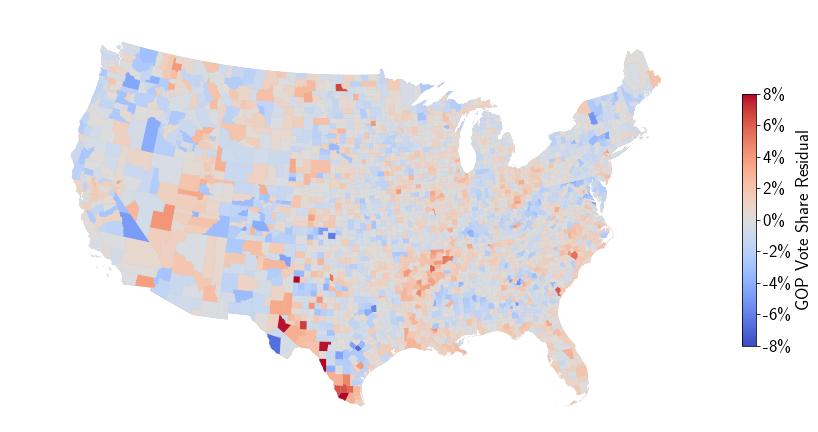

In [28]:
plotDF = gp.GeoDataFrame(results_global['Residuals'],geometry=results_global['geometry'])
if not plotDF.crs:
    plotDF.crs={'init': 'epsg:4269'}
lambertStringEast = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=39.5 +lon_0=-98 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

fig = plt.figure(figsize=[10,10])

vmin = -8.0
vmax = 8.0
#East
ax = plt.axes([0,0.0,1.,1.0], projection=ccrs.LambertConformal(), frameon=False)
ax.set_extent([-120.0, -70., 22, 50])
usa.to_crs(lambertStringEast).plot(color='silver',ax=ax, label = 'Other states')
plotDF.dropna().to_crs(lambertStringEast).plot(column='Residuals', cmap='coolwarm',ax=ax,vmin=vmin, vmax=vmax)

axc = plt.axes([1.02, 0.32, 0.02, 0.35], frameon=False)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
numTicks = 9
cbarStep=float((vmax-vmin)/(numTicks-1.0))
cb = mpl.colorbar.ColorbarBase(axc, ticks=np.linspace(vmin, vmax, numTicks),cmap=cm.coolwarm,norm=norm,orientation='vertical')
cb.set_ticklabels(['{:.0f}\%'.format(int(x)) for x in np.arange(1.*vmin, 1.*(vmax+cbarStep), cbarStep)])
cb.set_label('GOP Vote Share Residual')


plt.savefig('global_residuals_map_2020.pdf',bbox_inches='tight')
plt.show()


In [29]:
np.sqrt(np.mean(results_global['Residuals']**2))

1.4958794381634581

## What if we trust the Texas v. Pennsylvania plaintiff states but nowhere else?


In [35]:
plaintiff_states = ['TX', 'MT', 'UT', 'ND', 'SD', 'NE', 'KS', 'OK', 'SC', 'TN', 'FL', 'LA', 'AL', 'MS', 'WV', 'IN', 'MO', 'AR']
defendant_states = ['PA', 'WI', 'MI', 'GA']
training_usa = usa.loc[[s[:2] in [state_codes[state] for state in plaintiff_states] for s in usa.index.values]] 
test_usa = usa.loc[[s[:2] not in [state_codes[state] for state in plaintiff_states] for s in usa.index.values]]


model = Pipeline([('std_scaler', StandardScaler()),('enet', ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1]))])
model.fit(training_usa[features], training_usa[label])

residuals_train = pd.DataFrame(index = training_usa.index, columns = ['Residuals', 'geometry'])
residuals_train['geometry'] = training_usa['geometry']
residuals_train['Residuals'] = 100.*(training_usa[label]-model.predict(training_usa[features]))

predictions = model.predict(test_usa[features])
results = pd.DataFrame(columns=['Residuals', 'geometry', 'abs_residuals', 'predicted', 'actual'])
results['Residuals'] = 100.*(test_usa[label]-predictions)
results['abs_residuals'] = np.abs(results['Residuals'])
results['predicted'] = predictions
results['actual'] = test_usa[label]
results['geometry'] = test_usa['geometry'].values

defendant_locs = np.where(np.logical_or(np.logical_or(np.logical_or(test_usa['STATEFP'].astype(int) == 42,
                                                                    test_usa['STATEFP'].astype(int) == 55),
                                                      test_usa['STATEFP'].astype(int) == 13),
                                       test_usa['STATEFP'].astype(int) == 26))


In [36]:
model['enet'].alpha_

0.004372037581156564

In [37]:
model['enet'].l1_ratio_

0.1

In [38]:
n_counties = len(defendant_locs[0])
Zz_defendant = np.zeros((1000000))
for i in trange(1000000):
    z = np.random.randn(n_counties)
    Zz_defendant[i] = np.max(np.abs(z))

100%|██████████| 1000000/1000000 [00:20<00:00, 48556.66it/s]


In [39]:
np.sqrt(np.mean(results.iloc[defendant_locs]['Residuals']**2))

1.5590593306497664

In [40]:
np.sqrt(np.mean(residuals_train['Residuals']**2))

1.5230968492749375

In [41]:
bin_heights, bin_borders= np.histogram(results.iloc[defendant_locs]['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])

for idx in results.iloc[defendant_locs].sort_values(by='abs_residuals', ascending=False).index[:10]:
    if results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1]<6:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' + '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'actual']) + '\% & ' + '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'predicted']) + ' & ' + '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']) +' & '+'{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ '{0:.1f}'.format(sigma_given_p(global_p_value(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1], Zz_defendant)))+'$\sigma$ \\')
    else:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' + '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'actual']) + '\% & ' + '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'predicted']) + ' & ' + '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']) +' & '+'{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ '-- \\')
        
        
for idx in results.iloc[defendant_locs].sort_values(by='abs_residuals', ascending=False).index[:10]:
    if results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1]<6:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' +
              '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'actual']) + '\% & ' +
              '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'predicted']) + '\% & ' +
              '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+
              '{0:.1f}'.format(sigma_given_p(global_p_value(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1], Zz_defendant)))+'$\sigma$ \\')
    else:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' & ' +
              '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'actual']) + '\% & ' +
              '{0:.1f}'.format(100*results.iloc[defendant_locs].loc[idx, 'predicted']) + '\% & ' +
              '{0:.1f}'.format(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ '-- \\')

Rockdale County, Georgia & 29.4\% & 0.4 & -6.6 & -5.3$\sigma$&4.0$\sigma$ \
Henry County, Georgia & 39.7\% & 0.5 & -6.3 & -5.0$\sigma$&3.7$\sigma$ \
Douglas County, Georgia & 37.3\% & 0.4 & -5.9 & -4.7$\sigma$&3.3$\sigma$ \
Webster County, Georgia & 53.9\% & 0.6 & -5.6 & -4.5$\sigma$&3.0$\sigma$ \
Menominee County, Wisconsin & 17.6\% & 0.2 & -4.8 & -3.9$\sigma$&2.1$\sigma$ \
Paulding County, Georgia & 64.7\% & 0.7 & -4.5 & -3.6$\sigma$&1.6$\sigma$ \
Quitman County, Georgia & 54.9\% & 0.6 & -4.1 & -3.3$\sigma$&1.0$\sigma$ \
Marquette County, Michigan & 44.3\% & 0.5 & -4.1 & -3.3$\sigma$&0.9$\sigma$ \
Keweenaw County, Michigan & 56.2\% & 0.6 & -3.8 & -3.1$\sigma$&0.6$\sigma$ \
Whitfield County, Georgia & 70.6\% & 0.7 & -3.6 & -2.9$\sigma$&0.3$\sigma$ \
Rockdale County, Georgia & 29.4\% & 36.0\% & -5.3$\sigma$&4.0$\sigma$ \
Henry County, Georgia & 39.7\% & 45.9\% & -5.0$\sigma$&3.7$\sigma$ \
Douglas County, Georgia & 37.3\% & 43.1\% & -4.7$\sigma$&3.3$\sigma$ \
Webster County, Georgia & 5

In [43]:

bin_heights, bin_borders= np.histogram(results.iloc[defendant_locs]['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])

for idx in results.iloc[defendant_locs].sort_values(by='abs_residuals', ascending=False).index[:10]:
    print('Name: ' + str(test_usa.loc[idx,'Geographic Area Name']))
    print('Predicted GOP share: '+str(results.loc[idx, 'predicted']))
    print('Actual GOP share: ' + str(results.loc[idx, 'actual']))
    print('Residual: ' + str(results.loc[idx, 'Residuals']))
    print('Local significance: ' + str(results.loc[idx, 'Residuals']/popt[1]))
    if results.loc[idx, 'Residuals']/popt[1]<6:
        print('Global significance: '+ str(sigma_given_p(global_p_value(results.loc[idx, 'Residuals']/popt[1], Zz_defendant))))
    print('')
    
bin_heights, bin_borders= np.histogram(results.iloc[defendant_locs]['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])

for idx in results.iloc[defendant_locs].sort_values(by='abs_residuals', ascending=False).index[:10]:
    if results_global.loc[idx, 'Residuals']/popt[1]<6:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' &' + str(results.iloc[defendant_locs].loc[idx, 'actual']) + '&' + str(results.iloc[defendant_locs].loc[idx, 'predicted']) + '&' + str(results.iloc[defendant_locs].loc[idx, 'Residuals']) +'&'+str(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ str(sigma_given_p(global_p_value(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1], Zz_defendant)))+'$\sigma$ \\')
    else:
        print(str(usa.loc[idx,'Geographic Area Name']) + ' &' + str(results.iloc[defendant_locs].loc[idx, 'actual']) + '&' + str(results.iloc[defendant_locs].loc[idx, 'predicted']) + '&' + str(results.iloc[defendant_locs].loc[idx, 'Residuals']) +'&'+str(results.iloc[defendant_locs].loc[idx, 'Residuals']/popt[1])+'$\sigma$' +'&'+ '-- \\')

Name: Rockdale County, Georgia
Predicted GOP share: 0.3597520632294569
Actual GOP share: 0.2940950486994644
Residual: -6.565701452999251
Local significance: -5.266160385031713
Global significance: 4.036080721614432

Name: Henry County, Georgia
Predicted GOP share: 0.45907101467395156
Actual GOP share: 0.3965341572036614
Residual: -6.253685747029014
Local significance: -5.015901557083089
Global significance: 3.7400748014960303

Name: Douglas County, Georgia
Predicted GOP share: 0.43149291992838334
Actual GOP share: 0.3728540458194176
Residual: -5.863887410896574
Local significance: -4.7032555175720745
Global significance: 3.3040660813216265

Name: Webster County, Georgia
Predicted GOP share: 0.5952850299720382
Actual GOP share: 0.5389048991354467
Residual: -5.638013083659155
Local significance: -4.522088213117496
Global significance: 3.0360607212144246

Name: Menominee County, Wisconsin
Predicted GOP share: 0.22429783167755712
Actual GOP share: 0.17583807716635041
Residual: -4.845975451

/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing


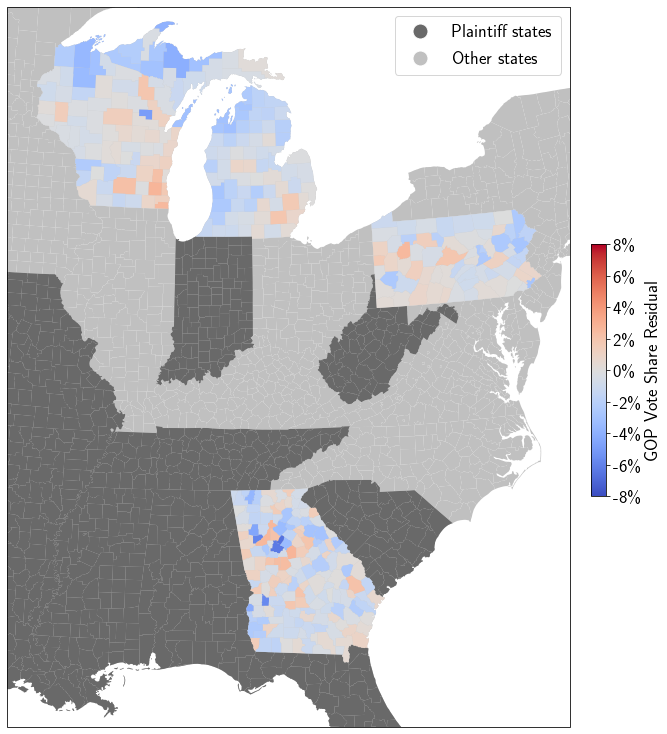

In [46]:
plotDF = gp.GeoDataFrame(results.iloc[defendant_locs]['Residuals'],geometry=results.iloc[defendant_locs]['geometry'])
plaintiffDF = gp.GeoDataFrame(training_usa['per_gop_2020'],geometry=training_usa['geometry'])
if not plotDF.crs:
    plotDF.crs={'init': 'epsg:4269'}
lambertStringEast = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=39 +lon_0=-86 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

fig = plt.figure(figsize=[10,10])

vmin = -8.0
vmax = 8.0
#East
ax = plt.axes([0,0.0,1.,1.0], projection=ccrs.LambertConformal(), frameon=True)
ax.set_extent([-102.0, -86., 29.1,47.])
usa.to_crs(lambertStringEast).plot(color='silver',ax=ax, label = 'Other states')
plaintiffDF.dropna().to_crs(lambertStringEast).plot(color = 'dimgray', ax = ax, label = 'Plaintiff states')
plotDF.dropna().to_crs(lambertStringEast).plot(column='Residuals', cmap='coolwarm',ax=ax,vmin=vmin, vmax=vmax)

axc = plt.axes([0.92, 0.32, 0.02, 0.35], frameon=False)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
numTicks = 9
cbarStep=float((vmax-vmin)/(numTicks-1.0))
cb = mpl.colorbar.ColorbarBase(axc, ticks=np.linspace(vmin, vmax, numTicks),cmap=cm.coolwarm,norm=norm,orientation='vertical')
cb.set_ticklabels(['{:.0f}\%'.format(int(x)) for x in np.arange(1.*vmin, 1.*(vmax+cbarStep), cbarStep)])
cb.set_label('GOP Vote Share Residual')


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Plaintiff states',markerfacecolor='dimgray', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Other states',markerfacecolor='silver', markersize=15)]
ax.legend(handles=legend_elements, loc=1)

plt.savefig('test_residuals_map_2020.pdf',bbox_inches='tight')
plt.show()


In [47]:
# See who would have won each state under the model
test_usa['predicted_D'] = (1.-predictions)*(test_usa['votes_dem_2020']+test_usa['votes_gop_2020'])
test_usa['predicted_R'] = predictions*(test_usa['votes_dem_2020']+test_usa['votes_gop_2020'])
test_usa.groupby('STATEFP').sum()[['predicted_D','predicted_R']]

/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,predicted_D,predicted_R
STATEFP,,
04,1.748299e+06,1.585530e+06
06,1.086020e+07,6.256480e+06
08,1.755196e+06,1.413763e+06
09,1.008924e+06,7.870475e+05
10,2.827200e+05,2.141510e+05
11,3.276327e+05,8.276267e+03
13,2.437745e+06,2.497742e+06
15,6.502598e+05,-8.726575e+04
16,2.862386e+05,5.549014e+05


## Sensitivity Testing: Texas v. Pennsylvania

In [54]:
wayne_FIPS = '26163'
philadelphia_FIPS = '42101'


In [124]:
tampered_usa = test_usa.copy()

In [56]:
tampered_usa.loc[wayne_FIPS,'votes_gop_2020'] 

264553

In [57]:
tampered_usa.loc[wayne_FIPS,'votes_dem_2020'] 

597170

In [58]:
667170/(667170+194553)

0.7742279131461038

In [59]:
597170/(264553+597170)

0.6929953128789645

In [60]:
0.7742279131461038-0.6929953128789645

0.0812326002671393

In [126]:

test_usa = usa.loc[[s[:2] not in [state_codes[state] for state in plaintiff_states] for s in usa.index.values]]

tampered_usa = test_usa.copy()
tampered_usa.loc[wayne_FIPS,'votes_gop_2020'] = tampered_usa.loc[wayne_FIPS,'votes_gop_2020']# - 70000
tampered_usa.loc[wayne_FIPS,'votes_dem_2020'] = tampered_usa.loc[wayne_FIPS,'votes_dem_2020'] + 150000
#tampered_usa.loc[philadelphia_FIPS,'votes_gop_2020'] = tampered_usa.loc[philadelphia_FIPS,'votes_gop_2020'] - 20000
#tampered_usa.loc[philadelphia_FIPS,'votes_dem_2020'] = tampered_usa.loc[philadelphia_FIPS,'votes_dem_2020'] + 20000
tampered_usa['per_dem_2020'] = tampered_usa['votes_dem_2020']/(tampered_usa['votes_dem_2020']+tampered_usa['votes_gop_2020'])
tampered_usa['per_gop_2020'] = tampered_usa['votes_gop_2020']/(tampered_usa['votes_dem_2020']+tampered_usa['votes_gop_2020'])

predictions = model.predict(tampered_usa[features])
results = pd.DataFrame(columns=['Residuals', 'geometry'])
results = pd.DataFrame(columns=['Residuals', 'geometry', 'abs_residuals', 'predicted', 'actual'])
results['Residuals'] =  100.*(tampered_usa[label]-predictions)
results['abs_residuals'] = np.abs(results['Residuals'])
results['predicted'] = predictions
results['actual'] = tampered_usa[label]
results['geometry'] = tampered_usa['geometry'].values

/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing
IllegalArgumentException: Argument must be Polygonal or LinearRing


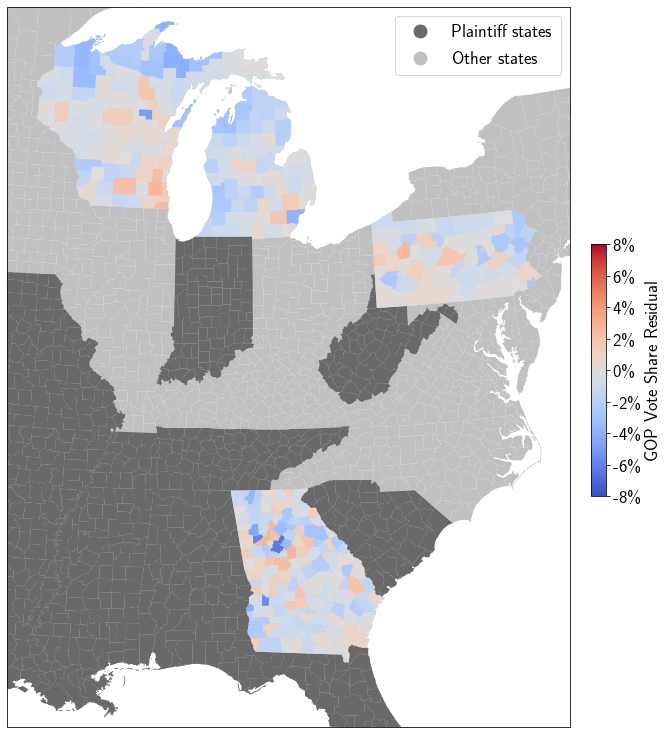

In [127]:
plotDF = gp.GeoDataFrame(results.iloc[defendant_locs]['Residuals'],geometry=results.iloc[defendant_locs]['geometry'])
plaintiffDF = gp.GeoDataFrame(training_usa['per_gop_2020'],geometry=training_usa['geometry'])
if not plotDF.crs:
    plotDF.crs={'init': 'epsg:4269'}
lambertStringEast = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=39 +lon_0=-86 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'

fig = plt.figure(figsize=[10,10])

vmin = -8.0
vmax = 8.0
#East
ax = plt.axes([0,0.0,1.,1.0], projection=ccrs.LambertConformal(), frameon=True)
ax.set_extent([-102.0, -86., 29.1,47.])
usa.to_crs(lambertStringEast).plot(color='silver',ax=ax, label = 'Other states')
plaintiffDF.dropna().to_crs(lambertStringEast).plot(color = 'dimgray', ax = ax, label = 'Plaintiff states')
plotDF.dropna().to_crs(lambertStringEast).plot(column='Residuals', cmap='coolwarm',ax=ax,vmin=vmin, vmax=vmax)

axc = plt.axes([0.92, 0.32, 0.02, 0.35], frameon=False)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
numTicks = 9
cbarStep=float((vmax-vmin)/(numTicks-1.0))
cb = mpl.colorbar.ColorbarBase(axc, ticks=np.linspace(vmin, vmax, numTicks),cmap=cm.coolwarm,norm=norm,orientation='vertical')
cb.set_ticklabels(['{:.0f}\%'.format(int(x)) for x in np.arange(1.*vmin, 1.*(vmax+cbarStep), cbarStep)])
cb.set_label('GOP Vote Share Residual')


legend_elements = [Line2D([0], [0], marker='o', color='w', label='Plaintiff states',markerfacecolor='dimgray', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Other states',markerfacecolor='silver', markersize=15)]
ax.legend(handles=legend_elements, loc=1)

plt.savefig('tampered_test_residuals_map_2020.pdf',bbox_inches='tight')
plt.show()


In [128]:
defendant_locs = np.where(np.logical_or(np.logical_or(np.logical_or(tampered_usa['STATEFP'].astype(int) == 42,
                                                                    tampered_usa['STATEFP'].astype(int) == 55),
                                                      tampered_usa['STATEFP'].astype(int) == 13),
                                       tampered_usa['STATEFP'].astype(int) == 26))

bin_heights, bin_borders= np.histogram(results.iloc[defendant_locs]['Residuals'].values, bins=bins)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
popt, pcov = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 1, 100.])

for idx in results.iloc[defendant_locs].sort_values(by='abs_residuals', ascending=False).index[:10]:
    print('Name: ' + str(tampered_usa.loc[idx,'Geographic Area Name']))
    print('Predicted GOP share: '+str(results.loc[idx, 'predicted']))
    print('Actual GOP share: ' + str(results.loc[idx, 'actual']))
    print('Residual: ' + str(results.loc[idx, 'Residuals']))
    print('Local significance: ' + str(results.loc[idx, 'Residuals']/popt[1]))
    if results.loc[idx, 'Residuals']/popt[1]<6:
        print('Global significance: '+ str(sigma_given_p(global_p_value(results.loc[idx, 'Residuals']/popt[1], Zz_defendant))))
    print('')


Name: Rockdale County, Georgia
Predicted GOP share: 0.3597520632294569
Actual GOP share: 0.2940950486994644
Residual: -6.565701452999251
Local significance: -5.267415366914067
Global significance: 4.036080721614432

Name: Henry County, Georgia
Predicted GOP share: 0.45907101467395156
Actual GOP share: 0.3965341572036614
Residual: -6.253685747029014
Local significance: -5.017096899632037
Global significance: 3.7400748014960303

Name: Douglas County, Georgia
Predicted GOP share: 0.43149291992838334
Actual GOP share: 0.3728540458194176
Residual: -5.863887410896574
Local significance: -4.7043763532533065
Global significance: 3.3040660813216265

Name: Webster County, Georgia
Predicted GOP share: 0.5952850299720382
Actual GOP share: 0.5389048991354467
Residual: -5.638013083659155
Local significance: -4.523165874708282
Global significance: 3.0400608012160246

Name: Menominee County, Wisconsin
Predicted GOP share: 0.22429783167755712
Actual GOP share: 0.17583807716635041
Residual: -4.845975451

In [75]:
michigan = test_usa.iloc[np.where(test_usa['STATEFP'] == '26')]
wisconsin = test_usa.iloc[np.where(test_usa['STATEFP'] == '55')]
pennsylvania = test_usa.iloc[np.where(test_usa['STATEFP'] == '42')]
georgia = test_usa.iloc[np.where(test_usa['STATEFP'] == '13')]


In [77]:
michigan['prediction'] = model.predict(michigan[features])
wisconsin['prediction'] = model.predict(wisconsin[features])
pennsylvania['prediction'] = model.predict(pennsylvania[features])
georgia['prediction'] = model.predict(georgia[features])

/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/acjohnso/Projects/anomalies/anomalies/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingW

In [135]:
mi_margin = np.sum(michigan['votes_dem_2020'])-np.sum(michigan['votes_gop_2020'])
big_mi = michigan.iloc[np.where(michigan['votes_gop_2020']>mi_margin)]
big_mi2 = michigan.iloc[np.where(michigan['votes_dem_2020']>mi_margin)]

wi_margin = np.sum(wisconsin['votes_dem_2020'])-np.sum(wisconsin['votes_gop_2020'])
big_wi = wisconsin.iloc[np.where(wisconsin['votes_gop_2020']>wi_margin)]
big_wi2 = wisconsin.iloc[np.where(wisconsin['votes_dem_2020']>wi_margin)]

pa_margin = np.sum(pennsylvania['votes_dem_2020'])-np.sum(pennsylvania['votes_gop_2020'])
big_pa = pennsylvania.iloc[np.where(pennsylvania['votes_gop_2020']>pa_margin)]
big_pa2 = pennsylvania.iloc[np.where(pennsylvania['votes_dem_2020']>pa_margin)]

ga_margin = np.sum(georgia['votes_dem_2020'])-np.sum(georgia['votes_gop_2020'])
big_ga = georgia.iloc[np.where(georgia['votes_gop_2020']>ga_margin)]
big_ga2 = georgia.iloc[np.where(georgia['votes_dem_2020']>ga_margin)]


In [132]:
mi_county_results = np.zeros((len(big_mi), 100))
x = np.linspace(0, 1.2*mi_margin/2., 100)
for i in range(len(big_mi)):
    mi_county_results[i] = [sigma_given_p(global_p_value(((big_mi.iloc[i]['votes_gop_2020']-x[j])/(big_mi.iloc[i]['votes_dem_2020']+big_mi.iloc[i]['votes_gop_2020'])-big_mi.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

wi_county_results = np.zeros((len(big_wi), 100))
x = np.linspace(0, 1.2*wi_margin/2., 100)
for i in range(len(big_wi)):
    wi_county_results[i] = [sigma_given_p(global_p_value(((big_wi.iloc[i]['votes_gop_2020']-x[j])/(big_wi.iloc[i]['votes_dem_2020']+big_wi.iloc[i]['votes_gop_2020'])-big_wi.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

pa_county_results = np.zeros((len(big_pa), 100))
x = np.linspace(0, 1.2*pa_margin/2., 100)
for i in range(len(big_pa)):
    pa_county_results[i] = [sigma_given_p(global_p_value(((big_pa.iloc[i]['votes_gop_2020']-x[j])/(big_pa.iloc[i]['votes_dem_2020']+big_pa.iloc[i]['votes_gop_2020'])-big_pa.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

ga_county_results = np.zeros((len(big_ga), 100))
x = np.linspace(0, 1.2*ga_margin/2., 100)
for i in range(len(big_ga)):
    ga_county_results[i] = [sigma_given_p(global_p_value(((big_ga.iloc[i]['votes_gop_2020']-x[j])/(big_ga.iloc[i]['votes_dem_2020']+big_ga.iloc[i]['votes_gop_2020'])-big_ga.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]


In [136]:
mi_county_results2 = np.zeros((len(big_mi2), 100))
x = np.linspace(0, 1.2*mi_margin/2., 100)
for i in range(len(big_mi2)):
    mi_county_results2[i] = [sigma_given_p(global_p_value(((big_mi2.iloc[i]['votes_gop_2020']+x[j])/(big_mi2.iloc[i]['votes_dem_2020']+big_mi2.iloc[i]['votes_gop_2020'])-big_mi2.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

wi_county_results2 = np.zeros((len(big_wi2), 100))
x = np.linspace(0, 1.2*wi_margin/2., 100)
for i in range(len(big_wi2)):
    wi_county_results2[i] = [sigma_given_p(global_p_value(((big_wi2.iloc[i]['votes_gop_2020']+x[j])/(big_wi2.iloc[i]['votes_dem_2020']+big_wi2.iloc[i]['votes_gop_2020'])-big_wi2.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

pa_county_results2 = np.zeros((len(big_pa2), 100))
x = np.linspace(0, 1.2*pa_margin/2., 100)
for i in range(len(big_pa2)):
    pa_county_results2[i] = [sigma_given_p(global_p_value(((big_pa2.iloc[i]['votes_gop_2020']+x[j])/(big_pa2.iloc[i]['votes_dem_2020']+big_pa2.iloc[i]['votes_gop_2020'])-big_pa2.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]

ga_county_results2 = np.zeros((len(big_ga2), 100))
x = np.linspace(0, 1.2*ga_margin/2., 100)
for i in range(len(big_ga2)):
    ga_county_results2[i] = [sigma_given_p(global_p_value(((big_ga2.iloc[i]['votes_gop_2020']+x[j])/(big_ga2.iloc[i]['votes_dem_2020']+big_ga2.iloc[i]['votes_gop_2020'])-big_ga2.iloc[i]['prediction'])/(0.01*popt[1]), Zz_defendant)) for j in range(100)]


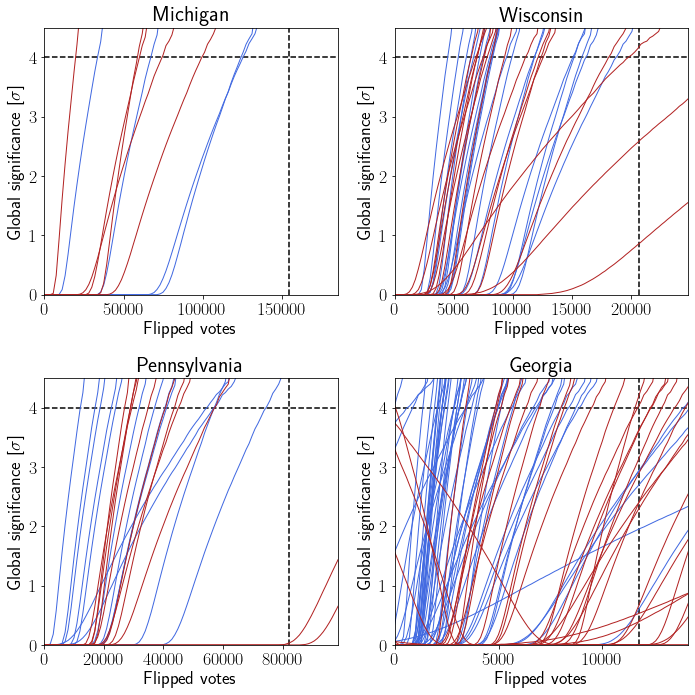

In [178]:
## Similar results for a variety of counties 
fig = plt.figure(figsize = [10,10])
plt.subplot(221)
plt.axhline(4.0, ls = '--', c='k', lw = 1.5)
plt.axvline(mi_margin, ls = '--', c='k', lw=1.5)
x = np.linspace(0, 1.2*mi_margin, 100)

for i in range(len(mi_county_results)):
    plt.plot(x, mi_county_results[i], c = 'royalblue', lw = 1)
for i in range(len(mi_county_results2)):
    plt.plot(x, mi_county_results2[i], c = 'firebrick', lw = 1)

plt.title('Michigan')
plt.ylabel('Global significance [$\sigma$]')
plt.xlabel('Flipped votes')
plt.ylim([0, 4.5])
plt.xlim([0, 1.2*mi_margin])
plt.subplot(222)
plt.axhline(4.0, ls = '--', c='k', lw = 1.5)
plt.axvline(wi_margin, ls = '--', c='k', lw=1.5)
x = np.linspace(0, 1.2*wi_margin, 100)

for i in range(len(wi_county_results)):
    plt.plot(x, wi_county_results[i], c = 'royalblue', lw = 1)
for i in range(len(wi_county_results2)):
    plt.plot(x, wi_county_results2[i], c = 'firebrick', lw = 1)

plt.title('Wisconsin')
plt.ylabel('Global significance [$\sigma$]')
plt.xlabel('Flipped votes')
plt.ylim([0, 4.5])
plt.xlim([0, 1.2*wi_margin])

plt.subplot(223)
plt.axhline(4.0, ls = '--', c='k', lw = 1.5)
plt.axvline(pa_margin, ls = '--', c='k', lw=1.5)
x = np.linspace(0, 1.2*pa_margin, 100)

for i in range(len(pa_county_results)):
    plt.plot(x, pa_county_results[i], c = 'royalblue', lw = 1)
for i in range(len(pa_county_results2)):
    plt.plot(x, pa_county_results2[i], c = 'firebrick', lw = 1)

plt.title('Pennsylvania')
plt.ylabel('Global significance [$\sigma$]')
plt.xlabel('Flipped votes')
plt.ylim([0, 4.5])
plt.xlim([0, 1.2*pa_margin])

plt.subplot(224)
plt.axhline(4.0, ls = '--', c='k', lw = 1.5)
plt.axvline(ga_margin, ls = '--', c='k', lw=1.5)
x = np.linspace(0, 1.2*ga_margin, 100)

for i in range(len(ga_county_results)):
    plt.plot(x, ga_county_results[i], c = 'royalblue', lw = 1)
for i in range(len(ga_county_results2)):
    plt.plot(x, ga_county_results2[i], c = 'firebrick', lw = 1)

plt.ylim([0, 4.5])
plt.xlim([0, 1.2*ga_margin])

plt.title('Georgia')
plt.ylabel('Global significance [$\sigma$]')
plt.xlabel('Flipped votes')
plt.tight_layout()
plt.show()